In [1]:
import re
import keyword
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from datasets import load_dataset
from rouge_score import rouge_scorer
import Levenshtein

## Loading the openai/humaneval dataset.

In [2]:
data = load_dataset("openai_humaneval", split="test")
data

Dataset({
    features: ['task_id', 'prompt', 'canonical_solution', 'test', 'entry_point'],
    num_rows: 164
})

In [3]:
first_20 = data.select(range(20))
print(first_20[0])

{'task_id': 'HumanEval/0', 'prompt': 'from typing import List\n\n\ndef has_close_elements(numbers: List[float], threshold: float) -> bool:\n    """ Check if in given list of numbers, are any two numbers closer to each other than\n    given threshold.\n    >>> has_close_elements([1.0, 2.0, 3.0], 0.5)\n    False\n    >>> has_close_elements([1.0, 2.8, 3.0, 4.0, 5.0, 2.0], 0.3)\n    True\n    """\n', 'canonical_solution': '    for idx, elem in enumerate(numbers):\n        for idx2, elem2 in enumerate(numbers):\n            if idx != idx2:\n                distance = abs(elem - elem2)\n                if distance < threshold:\n                    return True\n\n    return False\n', 'test': "\n\nMETADATA = {\n    'author': 'jt',\n    'dataset': 'test'\n}\n\n\ndef check(candidate):\n    assert candidate([1.0, 2.0, 3.9, 4.0, 5.0, 2.2], 0.3) == True\n    assert candidate([1.0, 2.0, 3.9, 4.0, 5.0, 2.2], 0.05) == False\n    assert candidate([1.0, 2.0, 5.9, 4.0, 5.0], 0.95) == True\n    assert can

In [4]:
first_20

Dataset({
    features: ['task_id', 'prompt', 'canonical_solution', 'test', 'entry_point'],
    num_rows: 20
})

In [5]:
def low_obfuscation(code: str) -> str:
    
    tokens = set(re.findall(r'\b[a-zA-Z_][a-zA-Z0-9_]*\b', code))
    reserved = set(keyword.kwlist)
    
    variables = {
        t for t in tokens
        if t not in reserved and len(t) > 1
    }

    mapping = {
        var: f"v{idx}"
        for idx, var in enumerate(sorted(variables))
    }

    def replace(match):
        word = match.group(0)
        return mapping.get(word, word)

    return re.sub(r'\b[a-zA-Z_][a-zA-Z0-9_]*\b', replace, code)

def high_obfuscation(code: str) -> str:
    
    code = re.sub(r'#.*', '', code)
    code = re.sub(r'("""[\s\S]*?"""|\'\'\'[\s\S]*?\'\'\')', '', code)

    tokens = re.findall(r'\b[a-zA-Z_][a-zA-Z0-9_]*\b', code)
    reserved = set(keyword.kwlist)

    identifiers = [
        t for t in set(tokens)
        if t not in reserved
    ]

    mapping = {
        name: f"X{idx}"
        for idx, name in enumerate(sorted(identifiers))
    }

    def replace(match):
        word = match.group(0)
        return mapping.get(word, word)

    code = re.sub(r'\b[a-zA-Z_][a-zA-Z0-9_]*\b', replace, code)
    code = re.sub(r'\n\s*\n', '\n', code)

    return code.strip()


Creating Low and High Obfuscation of the first 20 prompts. 
## Low Obfuscation
In Low Obfuscation, variables are first filtered. Keywords, builtins and variables with length 1 is ignored and the rest of the variables are renamed. 
## High Obfuscation
In High Obfuscation, comments and docstrings are removed. It 

In [6]:
def obfuscate_example(example):
    prompt = example["prompt"]
    example["prompt_low_obf"] = low_obfuscation(prompt)
    example["prompt_high_obf"] = high_obfuscation(prompt)
    return example

In [7]:
obfuscatedfirst_20_dataset = first_20.map(obfuscate_example)

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

In [8]:
obfuscatedfirst_20_dataset

Dataset({
    features: ['task_id', 'prompt', 'canonical_solution', 'test', 'entry_point', 'prompt_low_obf', 'prompt_high_obf'],
    num_rows: 20
})

Loading the model "Salesforce/codet5-small" 

In [9]:
model_name = "Salesforce/codet5-small"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

In [10]:
def generate_completion(prompt, max_new_tokens=256):
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=512
    )

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,  # deterministic
        )

    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [11]:
rouge = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)

def utility_score(completion, reference):
    score = rouge.score(reference, completion)
    return score["rougeL"].fmeasure


def privacy_score(original_prompt, obfuscated_prompt):
    dist = Levenshtein.distance(original_prompt, obfuscated_prompt)
    return dist / max(len(original_prompt), 1)

In [12]:
results = []

for example in obfuscatedfirst_20_dataset:
    task_id = example["task_id"]
    canonical = example["canonical_solution"]
    original_prompt = example["prompt"]

    prompt_variants = {
        "original": original_prompt,
        "low_obf": example["prompt_low_obf"],
        "high_obf": example["prompt_high_obf"],
    }

    for variant, prompt in prompt_variants.items():
        completion = generate_completion(prompt)

        results.append({
            "task_id": task_id,
            "variant": variant,
            "utility_rougeL": utility_score(completion, canonical),
            "privacy_levenshtein": privacy_score(original_prompt, prompt),
            "completion": completion
        })



In [13]:
results

[{'task_id': 'HumanEval/0',
  'variant': 'original',
  'utility_rougeL': 0.09090909090909093,
  'privacy_levenshtein': 0.0,
  'completion': 'has_close_elements(numbers: List[float], threshold:float):\n   0.5)\n   0.5)\n   0.5)\n   0.5)\n   0.5)\n   '},
 {'task_id': 'HumanEval/0',
  'variant': 'low_obf',
  'utility_rougeL': 0.0,
  'privacy_levenshtein': 0.4942528735632184,
  'completion': 'v1v1[v7]v1[v7]v1[v7]v1[v7]v1[v7]v1[v7]v1[v7]v1[v7]v1[v7]v1[v7]v1[v7]v1[v7]v1[v7]v1['},
 {'task_id': 'HumanEval/0',
  'variant': 'high_obf',
  'utility_rougeL': 0.0,
  'privacy_levenshtein': 0.9051724137931034,
  'completion': 'X0[X1]'},
 {'task_id': 'HumanEval/1',
  'variant': 'original',
  'utility_rougeL': 0,
  'privacy_levenshtein': 0.0,
  'completion': '****************************************************'},
 {'task_id': 'HumanEval/1',
  'variant': 'low_obf',
  'utility_rougeL': 0.0,
  'privacy_levenshtein': 0.6106719367588933,
  'completion': "v28v28v28('( )v28('(v28('(v28('(v28('(v28('(v28('(v28

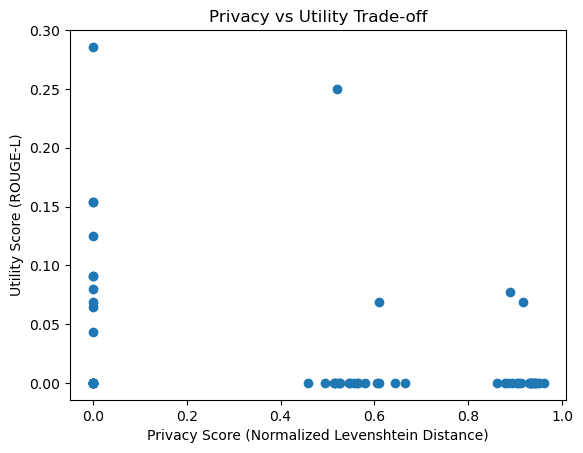

In [14]:
import matplotlib.pyplot as plt

# Separate by variant
privacy = [r["privacy_levenshtein"] for r in results]
utility = [r["utility_rougeL"] for r in results]
labels = [r["variant"] for r in results]

plt.figure()
plt.scatter(privacy, utility)

plt.xlabel("Privacy Score (Normalized Levenshtein Distance)")
plt.ylabel("Utility Score (ROUGE-L)")
plt.title("Privacy vs Utility Trade-off")

plt.show()


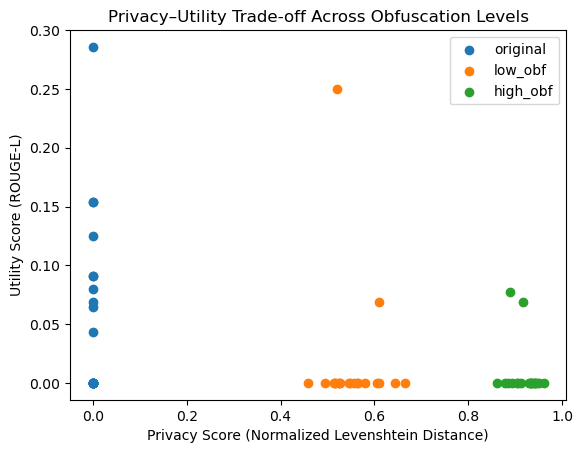

In [15]:
plt.figure()

for variant in ["original", "low_obf", "high_obf"]:
    subset = [r for r in results if r["variant"] == variant]
    plt.scatter(
        [r["privacy_levenshtein"] for r in subset],
        [r["utility_rougeL"] for r in subset],
        label=variant
    )

plt.xlabel("Privacy Score (Normalized Levenshtein Distance)")
plt.ylabel("Utility Score (ROUGE-L)")
plt.title("Privacy–Utility Trade-off Across Obfuscation Levels")
plt.legend()
plt.show()


## Utility Score
The Utility Score measures the extent to which a model's completion meets a task relative to a perfect response. It is typically assessed utilizing ROUGE (Recall-Oriented Understudy for Gisting Evaluation).

## Privacy Score
The Privacy Score measures how much a prompt or response conceals or alters sensitive original information.Levenshtein Distance measures the least number of single-character modifications (insertions, deletions, or replacements) needed to change one string into a different one.
1 indicates increased utility, while 1 signifies enhanced privacy.
## Analysis
1 indicates increased utility, while 1 signifies enhanced privacy. From the plot we notice, there exisits a trade-off. Prompts without obfuscation have range of utility score. When low obfuscation is applied, Privacy score imporves and unitily score reduced.For most prompts, utility socre has gone down to 0 with an average privacy score around 0.6 . Intrestingly for high obfuscation based prompts, privacy score increases to between 0.8 to 1.0. However, utility score remains 0.0 except for two prompts. This utility score is reduced from low obfuscation in high obfuscation prompts. This shows that with increase in privacy in prompts reduces the utility socre of the prompts and increases in privacy. This trade off exists and is visible in the above plot. 